Summary of the code
### Data Preparation and Preprocessing

1. **Loading Data**:
   - Reads a CSV file (`Tweets.csv`) containing tweets and their associated sentiment labels into a Pandas DataFrame (`df`).
   - Selects only the 'text' and 'airline_sentiment' columns from the DataFrame.

2. **Data Cleaning**:
   - Drops any rows with missing values (`NaN`) from the DataFrame.

3. **Label Encoding**:
   - Uses `LabelEncoder` from Scikit-learn to convert categorical sentiment labels ('positive', 'neutral', 'negative') into numeric labels (`0`, `1`, `2`).

4. **Train-Test Split**:
   - Splits the dataset into training (`X_train`, `y_train`) and testing (`X_test`, `y_test`) sets using `train_test_split` from Scikit-learn.
   - The text data (`X_train` and `X_test`) is used for training and evaluating the model, while `y_train` and `y_test` contain the corresponding numeric sentiment labels.

### Text Tokenization and Padding

5. **Tokenization**:
   - Uses `Tokenizer` from Keras to tokenize the text data (`X_train`) and fit it on the training set.

6. **Sequence Padding**:
   - Converts the tokenized sequences (`X_train_seq` and `X_test_seq`) into sequences of uniform length (`max_seq_length`) using `pad_sequences` from Keras. This ensures all input sequences have the same length for model training.

### Model Building

7. **LSTM Model Definition**:
   - Constructs a Sequential model (`model`) using Keras.
   - Adds layers:
     - Embedding layer for word embeddings.
     - SpatialDropout1D layer for regularization.
     - LSTM layer with dropout to learn from sequences.
     - Dense layer with softmax activation for multi-class classification (3 classes: positive, neutral, negative).

8. **Model Compilation**:
   - Compiles the model with 'sparse_categorical_crossentropy' loss function for multi-class classification and 'adam' optimizer.
   - Specifies 'accuracy' as the metric to monitor during training.

### Model Training

9. **Training**:
   - Trains the LSTM model (`model`) on the training data (`X_train_pad`, `y_train`) for a specified number of epochs (`epochs`) and batch size (`batch_size`).
   - Validates the model on the testing data (`X_test_pad`, `y_test`).

10. **Model Evaluation**:
    - Evaluates the trained model on the testing data and prints the test accuracy.

11. **Model and Tokenizer Saving**:
    - Saves the trained LSTM model (`model`) as a `.h5` file ('sentiment_lstm_model.h5').
    - Saves the `Tokenizer` object (`tokenizer`) used for tokenization as a pickle file ('tokenizer.pickle').

### Sentiment Prediction on New Dataset

12. **Loading Trained Model and Tokenizer**:
    - Loads the saved model ('sentiment_lstm_model.h5') and tokenizer ('tokenizer.pickle').

13. **Processing New Dataset**:
    - Reads another CSV file (`01tweet.csv`) containing new tweets into a Pandas DataFrame (`df_01tweet`).
    - Retrieves only the 'text' column from this DataFrame.

14. **Tokenization and Padding for New Data**:
    - Tokenizes and pads the sequences of new tweets (`texts_01tweet`) using the loaded tokenizer and `pad_sequences`.

15. **Sentiment Prediction**:
    - Uses the loaded LSTM model to predict sentiment probabilities (`predictions`) for the new tweets.
    - Determines the predicted sentiment labels (`predicted_labels`) by selecting the class with the highest probability.

### Clustering and Rating

16. **Clustering Using K-Means**:
    - Applies K-Means clustering to the predicted sentiment probabilities (`predictions`) to group tweets into clusters.
    - Uses the elbow method to determine the optimal number of clusters (`optimal_k`) based on the sum of squared distances.

17. **Assigning Ratings**:
    - Assigns ratings (`1`, `2`, `3`, etc.) to each tweet based on the cluster it belongs to.

18. **Output**:
    - Constructs a DataFrame (`result_df`) with columns for tweet text, predicted sentiment, assigned cluster, and rating.
    - Prints each tweet along with its predicted sentiment and assigned rating.

### Visualization

19. **Elbow Method Visualization**:
    - Plots the sum of squared distances for different numbers of clusters (`K`) to visualize the optimal number of clusters using the elbow method.

### Summary

This code performs end-to-end tasks for sentiment analysis:
- It prepares the data by cleaning and encoding sentiment labels.
- Builds and trains an LSTM model for sentiment classification.
- Saves the trained model and tokenizer for future use.
- Predicts sentiments on new tweets and assigns ratings based on clustering.
- Visualizes the elbow method to determine the optimal number of clusters.


In [21]:
import warnings
warnings.filterwarnings('ignore') #warnings from colab environment are ignored

In [22]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder #imported necessary libraries

df = pd.read_csv('/content/Tweets.csv')
df = df[['text', 'airline_sentiment']]

df.dropna(inplace=True)

label_encoder = LabelEncoder()
df['airline_sentiment'] = label_encoder.fit_transform(df['airline_sentiment'])

X_train, X_test, y_train, y_test = train_test_split(df['text'], df['airline_sentiment'], test_size=0.2, random_state=42)
tokenizer = Tokenizer(num_words=5000, lower=True)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_seq_length = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_seq_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_seq_length)

model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=max_seq_length))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

batch_size = 64
epochs = 10 #epochs can be adjusted (more epochs are better)
history = model.fit(X_train_pad, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test_pad, y_test), verbose=2)

loss, accuracy = model.evaluate(X_test_pad, y_test, verbose=2)
print(f'Test Accuracy: {accuracy}')

model.save('sentiment_lstm_model.h5') #saves the model

import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

print('Model and tokenizer saved.')


Epoch 1/10
183/183 - 49s - loss: 0.7041 - accuracy: 0.7101 - val_loss: 0.5414 - val_accuracy: 0.7930 - 49s/epoch - 266ms/step
Epoch 2/10
183/183 - 35s - loss: 0.4581 - accuracy: 0.8225 - val_loss: 0.4872 - val_accuracy: 0.8098 - 35s/epoch - 189ms/step
Epoch 3/10
183/183 - 35s - loss: 0.3544 - accuracy: 0.8660 - val_loss: 0.5144 - val_accuracy: 0.8016 - 35s/epoch - 191ms/step
Epoch 4/10
183/183 - 42s - loss: 0.2933 - accuracy: 0.8927 - val_loss: 0.5531 - val_accuracy: 0.7947 - 42s/epoch - 227ms/step
Epoch 5/10
183/183 - 39s - loss: 0.2467 - accuracy: 0.9103 - val_loss: 0.5991 - val_accuracy: 0.8040 - 39s/epoch - 212ms/step
Epoch 6/10
183/183 - 34s - loss: 0.2168 - accuracy: 0.9213 - val_loss: 0.6323 - val_accuracy: 0.7828 - 34s/epoch - 184ms/step
Epoch 7/10
183/183 - 35s - loss: 0.1760 - accuracy: 0.9353 - val_loss: 0.7033 - val_accuracy: 0.7865 - 35s/epoch - 190ms/step
Epoch 8/10
183/183 - 34s - loss: 0.1584 - accuracy: 0.9443 - val_loss: 0.7318 - val_accuracy: 0.7818 - 34s/epoch - 188

In [23]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
model = tf.keras.models.load_model('sentiment_lstm_model.h5')

# Load the tokenizer
import pickle
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)


In [24]:
#1Tweet Dataset
df_01tweet = pd.read_csv('/content/01tweet.csv')
texts_01tweet = df_01tweet['text']

texts_01tweet_seq = tokenizer.texts_to_sequences(texts_01tweet)
max_seq_length = 100
texts_01tweet_pad = pad_sequences(texts_01tweet_seq, maxlen=max_seq_length)


In [25]:
#Sentiment Prediction
predictions = model.predict(texts_01tweet_pad)
predicted_labels = np.argmax(predictions, axis=1)


1/1 [==============================] - 0s 220ms/step


In [26]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

model = tf.keras.models.load_model('sentiment_lstm_model.h5')

import pickle
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

df_01tweet = pd.read_csv('/content/01tweet.csv')
texts_01tweet = df_01tweet['text']

texts_01tweet_seq = tokenizer.texts_to_sequences(texts_01tweet)
max_seq_length = 100
texts_01tweet_pad = pad_sequences(texts_01tweet_seq, maxlen=max_seq_length)

predictions = model.predict(texts_01tweet_pad)
predicted_labels = np.argmax(predictions, axis=1)
label_encoder = LabelEncoder()
df = pd.read_csv('/content/Tweets.csv')
df = df[['text', 'airline_sentiment']]
df.dropna(inplace=True)
label_encoder.fit(df['airline_sentiment'])
sentiment_labels = label_encoder.inverse_transform(predicted_labels)

for text, sentiment in zip(texts_01tweet, sentiment_labels):
    print(f'Tweet: {text}')
    print(f'Predicted Sentiment: {sentiment}')
    print('---')

1/1 [==============================] - 0s 226ms/step
Tweet: @VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)
Predicted Sentiment: positive
---


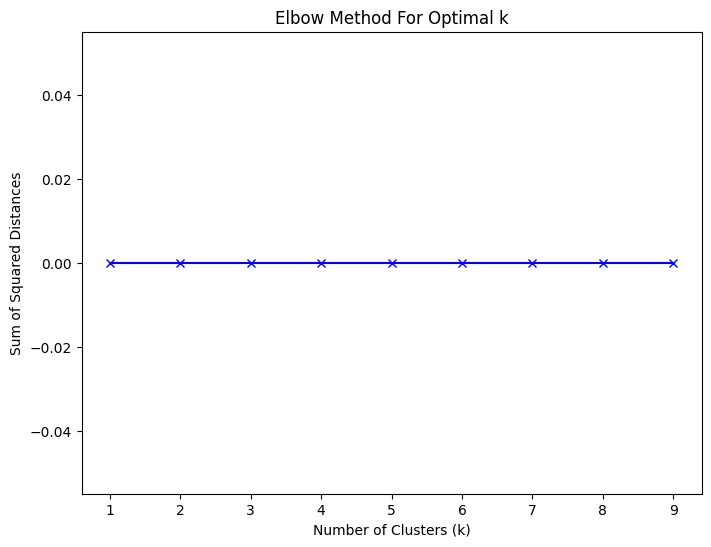

In [27]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

kmeans_data = predictions

sum_of_squared_distances = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=1, random_state=42)
    kmeans.fit(kmeans_data)
    sum_of_squared_distances.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method For Optimal k')
plt.show()


1/1 [==============================] - 0s 236ms/step


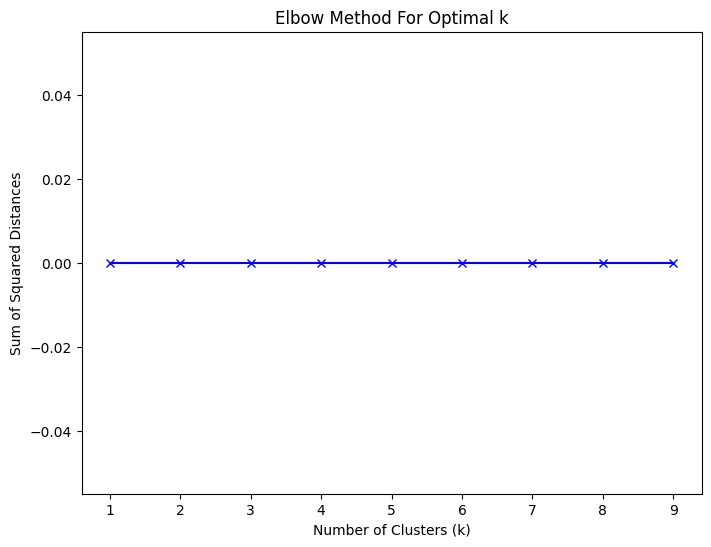

Tweet: @VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)
Predicted Sentiment: positive
Rating: 1
---


In [28]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import pickle

model = tf.keras.models.load_model('sentiment_lstm_model.h5')
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

df_01tweet = pd.read_csv('/content/01tweet.csv')
texts_01tweet = df_01tweet['text']

texts_01tweet_seq = tokenizer.texts_to_sequences(texts_01tweet)
max_seq_length = 100
texts_01tweet_pad = pad_sequences(texts_01tweet_seq, maxlen=max_seq_length)

predictions = model.predict(texts_01tweet_pad)
predicted_labels = np.argmax(predictions, axis=1)

kmeans_data = predictions

sum_of_squared_distances = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=1, random_state=42)
    kmeans.fit(kmeans_data)
    sum_of_squared_distances.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method For Optimal k')
plt.show()

optimal_k = 3
kmeans = KMeans(n_clusters=1, random_state=42)
clusters = kmeans.fit_predict(kmeans_data)

df = pd.read_csv('/content/Tweets.csv')
df = df[['text', 'airline_sentiment']]
df.dropna(inplace=True)
label_encoder.fit(df['airline_sentiment'])
sentiment_labels = label_encoder.inverse_transform(predicted_labels)


cluster_ratings = {i: rating for i, rating in enumerate(range(1, optimal_k + 1))}

result_df = pd.DataFrame({
    'text': texts_01tweet,
    'predicted_sentiment': sentiment_labels,
    'cluster': clusters,
    'rating': [cluster_ratings[cluster] for cluster in clusters]
})

for index, row in result_df.iterrows():
    print(f'Tweet: {row["text"]}')
    print(f'Predicted Sentiment: {row["predicted_sentiment"]}')
    print(f'Rating: {row["rating"]}')
    print('---')
